In [13]:
import re
import random
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import pipeline


In [14]:
dataset = load_dataset("amazon_polarity")
dataset


README.md: 0.00B [00:00, ?B/s]

amazon_polarity/train-00000-of-00004.par(…):   0%|          | 0.00/260M [00:00<?, ?B/s]

amazon_polarity/train-00001-of-00004.par(…):   0%|          | 0.00/258M [00:00<?, ?B/s]

amazon_polarity/train-00002-of-00004.par(…):   0%|          | 0.00/255M [00:00<?, ?B/s]

amazon_polarity/train-00003-of-00004.par(…):   0%|          | 0.00/254M [00:00<?, ?B/s]

amazon_polarity/test-00000-of-00001.parq(…):   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})

In [15]:
for i in range(3):
    sample = dataset["train"][i]
    print("Label:", sample["label"])
    print("Review:", sample["content"])
    print()


Label: 1
Review: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^

Label: 1
Review: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.

Label: 1
Review: This soundtrack is my favorite music of all time, hands down. The intense sadness

In [16]:
def clean_text_basic(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

clean_text_basic(dataset["train"][0]["content"])


'this sound track was beautiful it paints the senery in your mind so well i would recomend it even to people who hate vid game music i have played the game chrono cross but out of all of the games i have ever played it has the best music it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras it would impress anyone who cares to listen'

In [18]:
subset = dataset['train'].select(range(300))
raw_texts = [row["content"] for row in subset]

def simple_tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

def corpus_stats(texts):
    all_tokens = []
    lengths = []
    for t in texts:
        tokens = simple_tokenize(t)
        all_tokens.extend(tokens)
        lengths.append(len(tokens))
    return {
        "vocab_size": len(set(all_tokens)),
        "avg_length": sum(lengths) / len(lengths)
    }

raw_stats = corpus_stats(raw_texts)
raw_stats


{'vocab_size': 4090, 'avg_length': 79.17666666666666}

In [19]:
cleaner = pipeline("text2text-generation", model="google/flan-t5-base", max_length=128)


Device set to use cuda:0


In [20]:
def llm_clean(text):
    prompt = (
        "Rewrite this product review in clear and correct English, "
        "improving grammar and readability while preserving meaning: "
        f"{text}"
    )
    result = cleaner(prompt)[0]['generated_text']
    return result.strip()

cleaned_texts = []
for i, row in enumerate(subset):
    cleaned_texts.append(llm_clean(row["content"]))
    if (i+1) % 50 == 0:
        print(f"Processed {i+1}/{len(subset)}")


Processed 50/300
Processed 100/300
Processed 150/300
Processed 200/300
Processed 250/300
Processed 300/300


In [21]:
clean_stats = corpus_stats(cleaned_texts)
raw_stats, clean_stats


({'vocab_size': 4090, 'avg_length': 79.17666666666666},
 {'vocab_size': 3236, 'avg_length': 63.82666666666667})

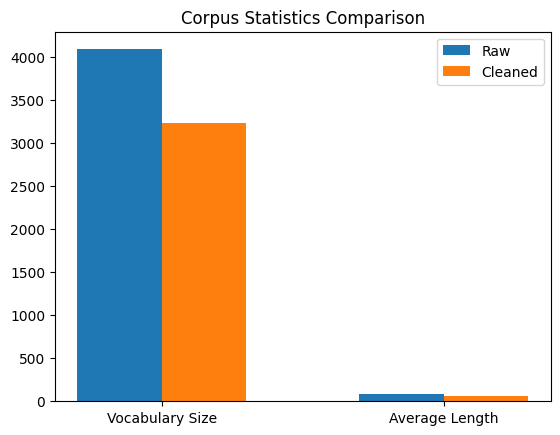

In [22]:
labels = ["Vocabulary Size", "Average Length"]
before = [raw_stats["vocab_size"], raw_stats["avg_length"]]
after = [clean_stats["vocab_size"], clean_stats["avg_length"]]

plt.figure()
x = range(len(labels))
plt.bar([i - 0.15 for i in x], before, width=0.3, label="Raw")
plt.bar([i + 0.15 for i in x], after, width=0.3, label="Cleaned")
plt.xticks(x, labels)
plt.title("Corpus Statistics Comparison")
plt.legend()
plt.show()


In [ ]:
import pandas as pd
df = pd.DataFrame({
    "label": [row["label"] for row in subset],
    "text_raw": raw_texts,
    "text_clean": cleaned_texts
})
df.to_csv("yelp_cleaned_llm.csv", index=False)
"CSV saved successfully!"


'CSV saved successfully!'